In [135]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
%matplotlib inline

## Create simulation data

In [136]:
# Set seed
np.random.seed(20200403)

In [137]:
# 1,000 firms (25 per state), 40 states, 4 groups (250 per groups), 30 years

df = pd.DataFrame({"state" : np.repeat(np.arange(1, 41), 25),
                   "firms" : np.random.uniform(0, 5, size = 1000)})

df = pd.concat([df] * 30, ignore_index = True).sort_values(['state', 'firms'])

df['year'] = list(range(1980, 2010)) * 1000

df['n'] = list(range(1, 31)) * 1000

df['id'] = np.repeat(np.arange(1, 1001), 30)

df.reset_index(drop = True, inplace = True)

df['group'] = np.repeat(np.arange(1, 5), len(df)/4)

In [139]:
# Add 250 firms treated every period with the treatment effect still 7 on average
# Cohort years 1986, 1992, 1998, 2004

def create_treat_date(row):
    if row['group'] == 1:
        return 1986
    elif row['group'] == 2:
        return 1992
    elif row['group'] == 3:
        return 1998
    else:
        return 2004
    
df['treat_date'] = df.apply(create_treat_date, axis = 1)

In [140]:
def create_treat(row):
    if (row['group'] == 1 and row['year'] >= 1986 or  
        row['group'] == 2 and row['year'] >= 1992 or 
        row['group'] == 3 and row['year'] >= 1998 or 
        row['group'] == 4 and row['year'] >= 2004):
        return 1
    else:
        return 0
    
df['treat'] = df.apply(create_treat, axis = 1)

In [142]:
# Data generating process 

def create_te(row):
    if row['group'] == 1:
        return np.random.normal(10, 0.2**2)
    elif row['group'] == 2:
        return np.random.normal(8, 0.2**2)
    elif row['group'] == 3:
        return np.random.normal(6, 0.2**2)
    else:
        return np.random.normal(4, 0.2**2)  
    
df['te'] = df.apply(create_te, axis = 1)
df['e'] = np.random.normal(0, 0.5**2, size = 30000)

* DGP: heterogeneous versus constant (but always across group heterogeneity)
* Cumulative treatment effect is te x (year - t_g + 1) -- Dynamic treatment effects over time for each group.
* How does (year - treat_date + 1) create dynamic ATT?  Assume treat_date is 1992 and it is year 2000. Then, te=8 x (2000 - 1992 + 1) = 8 x (9) = 72. Group 2's TE rises from an 8 up to 72 in the t+8 year.

In [221]:
# Constant treatment effects.  Notice, the treatment effect is constant. 
df['y2'] = (df['firms'] + df['n'] + df['te']*df['treat'] + df['e'])
# Data generating process with heterogeneity over time
df['y'] = (df['firms'] + df['n'] + df['treat']*df['te']*(
    df['year'] - df['treat_date'] + 1) + df['e'])

In [144]:
df['individual'] = df['id']
df['time'] = df['year']
df = df.set_index(['individual', 'time'])

* For group 1, the ATT in 1986 is 10
* For group 1, the ATT in 1987 is 20
* For group 1, the ATT in 1988 is 30 and so on
* This is what we mean by "dynamic treatment effects" or "heterogeneity over time"

## Estimation

In [145]:
# Estimation using TWFE - constant treatment effects
constant_te = PanelOLS.from_formula('y2 ~ 1 + treat + C(year) + EntityEffects', 
                                    data = df).fit(cov_type = 'robust')
print(constant_te)

                          PanelOLS Estimation Summary                           
Dep. Variable:                     y2   R-squared:                        0.9943
Estimator:                   PanelOLS   R-squared (Between):              0.6274
No. Observations:               30000   R-squared (Within):               0.9943
Date:                Tue, Feb 15 2022   R-squared (Overall):              0.9688
Time:                        21:45:57   Log-likelihood                -3.782e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                   1.682e+05
Entities:                        1000   P-value                           0.0000
Avg Obs:                       30.000   Distribution:                F(30,28970)
Min Obs:                       30.000                                           
Max Obs:                       30.000   F-statistic (robust):          1.581e+05
                            

In [146]:
# Estimation using TWFE - heterogenous treatment effects over time
het_te = PanelOLS.from_formula('y ~ 1 + treat + C(year) + EntityEffects', 
                               data = df).fit(cov_type = 'robust')
print(het_te)

                          PanelOLS Estimation Summary                           
Dep. Variable:                      y   R-squared:                        0.7229
Estimator:                   PanelOLS   R-squared (Between):             -0.0784
No. Observations:               30000   R-squared (Within):               0.7229
Date:                Tue, Feb 15 2022   R-squared (Overall):              0.4704
Time:                        21:45:58   Log-likelihood                -1.437e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2519.8
Entities:                        1000   P-value                           0.0000
Avg Obs:                       30.000   Distribution:                F(30,28970)
Min Obs:                       30.000                                           
Max Obs:                       30.000   F-statistic (robust):             2084.7
                            

### Sun and Abraham event study commentary

In [147]:
# Leads and lags
df['time_til'] = df['year'] - df['treat_date']
df['cons'] = 1
df = pd.concat([df, pd.get_dummies(df['time_til'], prefix = "dd")], axis = 1)

In [148]:
dd = [dd for dd in df.columns if dd.startswith("dd_")]

##### Event study with heterogeneity, dropping two leads

In [150]:
leads = {'dd_-4', 'dd_-1'}
ind_cols = [ind for ind in dd if ind not in leads]

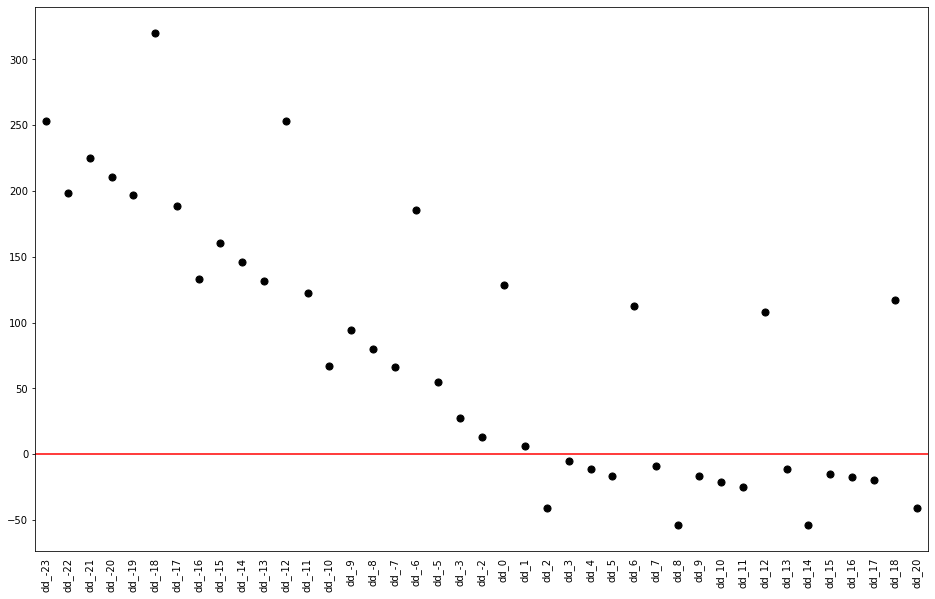

In [167]:
het_eventstudy = PanelOLS(df.y, df[ind_cols],  
                         entity_effects = True, time_effects = True,
                         check_rank = False, drop_absorbed = True).fit(cov_type = 'robust')

het_err_series = het_eventstudy.params - het_eventstudy.conf_int()['lower']
het_coef_df = pd.DataFrame({'coef': het_eventstudy.params.values[1:48],
                        'err': het_err_series.values[1:48],
                        'varname': het_err_series.index.values[1:48]
                       })

fig, ax = plt.subplots(figsize = (16, 10))
het_coef_df.plot(x = 'varname', y = 'coef', kind = 'bar', 
             ax = ax, color = 'none', 
             yerr = 'err', legend = False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.axhline(y = 0, color= 'r', linestyle='-')
ax.scatter(x = np.arange(het_coef_df.shape[0]), 
           marker = 'o', s = 50, 
           y = het_coef_df['coef'], color = 'black')
ax.xaxis.set_ticks_position('none')

##### Event study with constant treatment effects, no anticipatory behavior and parallel trends (Sun and Abraham 2020). Droppping two leads.

In [164]:
leads_2 = {'dd_-24', 'dd_-4', 'dd_-1'}
ind_cols_2 = [ind for ind in dd if ind not in leads_2]

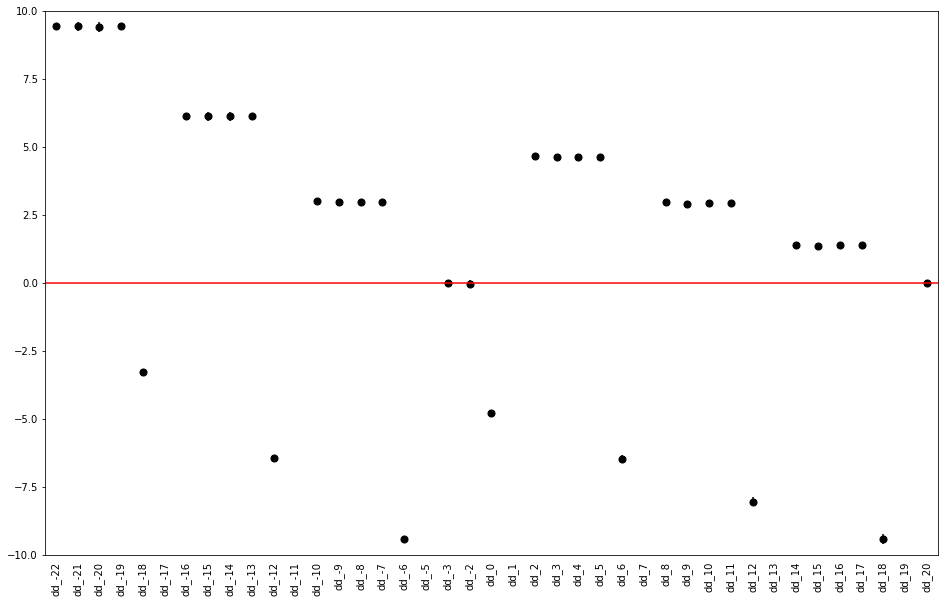

In [170]:
constant_eventstudy = PanelOLS(df.y2, df[ind_cols_2],  
                         entity_effects = True, time_effects = True,
                         check_rank = False, drop_absorbed = True).fit(cov_type = 'robust')

err_series = constant_eventstudy.params - constant_eventstudy.conf_int()['lower']
cons_coef_df = pd.DataFrame({'coef': constant_eventstudy.params.values[1:],
                        'err': err_series.values[1:],
                        'varname': err_series.index.values[1:]
                       })

fig, ax = plt.subplots(figsize = (16, 10))
cons_coef_df.plot(x = 'varname', y = 'coef', kind = 'bar', 
             ax = ax, color = 'none', 
             yerr ='err', legend = False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(-10, 10)
ax.axhline(y = 0, color='r', linestyle='-')
ax.scatter(x = np.arange(cons_coef_df.shape[0]), 
           marker = 'o', s = 50, 
           y = cons_coef_df['coef'], color = 'black')
ax.xaxis.set_ticks_position('none')

In [172]:
leads = pd.get_dummies(df['time_til'][df['time_til'] < -1], prefix = "leads", 
                      prefix_sep = "_", drop_first = False)

lags = pd.get_dummies(df['time_til'][df['time_til'] > 0], prefix = "lags", 
                      prefix_sep = "_", drop_first = False)

In [173]:
leads_lags = pd.concat([leads, lags], axis = 0)
df = pd.concat([df, leads_lags], axis = 1)

In [175]:
def create_lead_til(row):
    if row['time_til'] < -1:
        return row['time_til']
    else:
        return 0
    
def create_lag_til(row):
    if row['time_til'] > 0:
        return row['time_til']
    else:
        return 0
    
df['lead_til'] = df.apply(create_lead_til, axis = 1)
df['lag_til'] = df.apply(create_lag_til, axis = 1)
df['abs_lead_til'] = abs(df['lead_til'])

In [199]:
%%capture

het_te = PanelOLS.from_formula("y2 ~ 1 + C(abs_lead_til):C(group) + C(lag_til):C(group) + EntityEffects", 
                               check_rank = False, drop_absorbed = True,
                               data = df).fit(cov_type = 'robust')

In [200]:
print(het_te)

                          PanelOLS Estimation Summary                           
Dep. Variable:                     y2   R-squared:                        0.9906
Estimator:                   PanelOLS   R-squared (Between):             -2.4929
No. Observations:               30000   R-squared (Within):               0.9906
Date:                Tue, Feb 15 2022   R-squared (Overall):              0.7486
Time:                        22:11:56   Log-likelihood                -4.538e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                   2.704e+04
Entities:                        1000   P-value                           0.0000
Avg Obs:                       30.000   Distribution:               F(112,28888)
Min Obs:                       30.000                                           
Max Obs:                       30.000   F-statistic (robust):          5.191e+05
                            

In [177]:
leads_3 = {'dd_-2', 'dd_-1'}
ind_cols_3 = [ind for ind in dd if ind not in leads_3]

In [202]:
het_te = PanelOLS(df.y2, df[ind_cols_3 + ['cons']], entity_effects = True, time_effects = True, 
                  check_rank = False, drop_absorbed = True).fit(cov_type = 'robust')
print(het_te)

                          PanelOLS Estimation Summary                           
Dep. Variable:                     y2   R-squared:                        0.9380
Estimator:                   PanelOLS   R-squared (Between):             -0.7056
No. Observations:               30000   R-squared (Within):              -0.1219
Date:                Tue, Feb 15 2022   R-squared (Overall):             -0.1624
Time:                        22:13:21   Log-likelihood                -2.308e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                   1.067e+04
Entities:                        1000   P-value                           0.0000
Avg Obs:                       30.000   Distribution:                F(41,28930)
Min Obs:                       30.000                                           
Max Obs:                       30.000   F-statistic (robust):             8822.8
                            

C:\Users\sajidmu2\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1831: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

dd_18, dd_19, dd_20, dd_21, dd_23

  warnings.warn(


### Bacon decomposition shows the problem -- notice all those late to early 2x2s!

In [203]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import IntVector, Formula
import rpy2.robjects.packages as rpackages
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind = 1)

<rpy2.rinterface_lib.sexp.NULLType object at 0x00000200D4FD3500> [RTYPES.NILSXP]

In [204]:
with localconverter(ro.default_converter + pandas2ri.converter):
      rdf = ro.conversion.py2rpy(df)

In [205]:
%%capture

# Bacon Decomposition
utils.install_packages("bacondecomp")
bacondecomp = rpackages.importr('bacondecomp')

In [209]:
get_df_y = bacondecomp.bacon(Formula('y ~ treat'), data = rdf, 
                  id_var = 'id', 
                  time_var = 'year')

with localconverter(ro.default_converter + pandas2ri.converter):
      decomp_df_y = ro.conversion.rpy2py(get_df_y)
        
decomp_df_y

                      type weight   avg_est
1 Earlier vs Later Treated    0.5  51.79904
2 Later vs Earlier Treated    0.5 -65.20756


,treated,untreated,estimate,weight,type
2,1992,1986,-44.002869,0.100000,Later vs Earlier Treated
3,1998,1986,-81.012049,0.133333,Later vs Earlier Treated
4,2004,1986,-106.007429,0.100000,Later vs Earlier Treated
5,1986,1992,34.999866,0.033333,Earlier vs Later Treated
7,1998,1992,-33.015604,0.066667,Later vs Earlier Treated
8,2004,1992,-57.995785,0.066667,Later vs Earlier Treated
9,1986,1998,65.000634,0.066667,Earlier vs Later Treated
10,1992,1998,27.987025,0.066667,Earlier vs Later Treated
12,2004,1998,-22.011540,0.033333,Later vs Earlier Treated
13,1986,2004,95.004862,0.100000,Earlier vs Later Treated


In [210]:
get_df_y2 = bacondecomp.bacon(Formula('y2 ~ treat'), data = rdf, 
                  id_var = 'id', 
                  time_var = 'year')

with localconverter(ro.default_converter + pandas2ri.converter):
      decomp_df_y2 = ro.conversion.rpy2py(get_df_y2)
        
decomp_df_y2

                      type weight avg_est
1 Earlier vs Later Treated    0.5 8.39645
2 Later vs Earlier Treated    0.5 5.59325


,treated,untreated,estimate,weight,type
2,1992,1986,8.000033,0.100000,Later vs Earlier Treated
3,1998,1986,5.999868,0.133333,Later vs Earlier Treated
4,2004,1986,3.987514,0.100000,Later vs Earlier Treated
5,1986,1992,10.001493,0.033333,Earlier vs Later Treated
7,1998,1992,5.983675,0.066667,Later vs Earlier Treated
8,2004,1992,3.992517,0.066667,Later vs Earlier Treated
9,1986,1998,10.003778,0.066667,Earlier vs Later Treated
10,1992,1998,7.983525,0.066667,Earlier vs Later Treated
12,2004,1998,3.984185,0.033333,Later vs Earlier Treated
13,1986,2004,10.001248,0.100000,Earlier vs Later Treated


* Callaway and Sant'anna (2018)
* When there are no coariates X and everybody eventually gets treated, Callaway & Sant'Anna (2018) suggest to estimate ATT(g,t) using
* ATT(g,t) = E [ (Gg/E[Gg] - ( 1-Dt)p/1-p/E[1-Dt] )( Yt - Y_{g-1}) ]

In [181]:
# Create group indicators
df = pd.concat([df, pd.get_dummies(df['group'], prefix = 'g', prefix_sep = "")], axis = 1)

* Estimate propensity scores. 
* In this setup where there is no "never treated" group, we need propensity scores per time period. 
* We can exploit the staggered rollout to simplify this a bit!
* Since I only know how to work things out well in the "wide" data format instead of the "long" data format, I simplify things a bit!
* pscore for Group 1986 that can be used until year 1991 (since at 1992 another set of units get treated)
* Note that I am using only a single year of data (this is because I want to use "wide format".)

In [182]:
logit_mod = sm.Logit.from_formula('g1 ~ 1', 
                                  data = df.query('(year == 1991) & ((g1 == 1) | (time_til < 0))')).fit()
df['pg1_1991'] = logit_mod.predict(df['g1']).g1

Optimization terminated successfully.
         Current function value: 0.562335
         Iterations 5


* Calculate ATT(1986,1986)
* This the the ATT for the group first treated at 1986 (g1==1) in the first period since treatment (1986)
* Gen outcomes (easiest way to transform data into wide form is this)

In [217]:
df['ypost'] = df['y'][df['year'] == 1986] 

df['ypre'] = df['y'][df['year'] == 1985]

# Generate denominators of the weights

df['g1_mean'] = df['g1'].groupby(df['year']).transform(lambda x: np.mean(x))

df['g1_cont_1991mean'] = df['pg1_1991'].groupby(df['year']).transform(lambda x: np.mean(
    (1 - df['g1'])*df['pg1_1991']/(1 - df['pg1_1991'])))

# Get weights

df['w1'] = df['g1']/df['g1_mean']

df['w0'] = ((1 - df['g1'])*df['pg1_1991']/(1 - df['pg1_1991']))/df['g1_cont_1991mean']

# Generate each component of the DID

att_11 = np.mean(df['w1']*df['ypost'])
att_10 = np.mean(df['w1']*df['ypre'])
att_01 =  np.mean(df['w0']*df['ypost'])
att_00 = np.mean(df['w0']*df['ypre'])

# Get the ATT(1986,1986)
att1986_1986 = (att_11 - att_10) -(att_01 - att_00)
att1986_1986

10.006858432324133

* Calculate ATT(1986,1987)
* This the the ATT for the group first treated at 1986 (g1==1) in the second period since treatment (1987)
* Gen outcomes (easiest way to transform data into wide form is this)

In [184]:
df['ypost'] = df['y'][df['year'] == 1987] 
df['ypre'] = df['y'][df['year'] == 1985]

df['g1_mean'] = df['g1'].groupby(df['year']).transform(lambda x: np.mean(x))
df['g1_cont_1991mean'] = df['pg1_1991'].groupby(df['year']).transform(
    lambda x: np.mean((1 - df['g1'])*df['pg1_1991']/(1 - df['pg1_1991'])))

df['w1'] = df['g1']/df['g1_mean']
df['w0'] = ((1 - df['g1'])*df['pg1_1991']/(1 - df['pg1_1991']))/df['g1_cont_1991mean']

att_11 = np.mean(df['w1']*df['ypost'])
att_10 = np.mean(df['w1']*df['ypre'])
att_01 =  np.mean(df['w0']*df['ypost'])
att_00 = np.mean(df['w0']*df['ypre'])

att1986_1987 = (att_11 - att_10) -(att_01 - att_00)
att1986_1987

19.97935546103527

In [185]:
df['ypost'] = df['y'][df['year'] == 1988] 
df['ypre'] = df['y'][df['year'] == 1985]

df['g1_mean'] = df['g1'].groupby(df['year']).transform(lambda x: np.mean(x))
df['g1_cont_1991mean'] = df['pg1_1991'].groupby(df['year']).transform(
    lambda x: np.mean((1 - df['g1'])*df['pg1_1991']/(1 - df['pg1_1991'])))

df['w1'] = df['g1']/df['g1_mean']
df['w0'] = ((1 - df['g1'])*df['pg1_1991']/(1 - df['pg1_1991']))/df['g1_cont_1991mean']

att_11 = np.mean(df['w1']*df['ypost'])
att_10 = np.mean(df['w1']*df['ypre'])
att_01 =  np.mean(df['w0']*df['ypost'])
att_00 = np.mean(df['w0']*df['ypre'])

att1986_1988 = (att_11 - att_10) -(att_01 - att_00)
att1986_1988

30.000872605079834

In [186]:
logit_mod = sm.Logit.from_formula('g1 ~ 1', data = df.query(
    '(year == 1997) & ((g1 == 1) | (time_til < 0))')).fit()
df['pg1_1997'] = logit_mod.predict(df['g1']).g1

Optimization terminated successfully.
         Current function value: 0.636514
         Iterations 4


In [187]:
df['ypost'] = df['y'][df['year'] == 1993] 
df['ypre'] = df['y'][df['year'] == 1985]

df['g1_mean'] = df['g1'].groupby(df['year']).transform(lambda x: np.mean(x))
df['g1_cont_1997mean'] = df['pg1_1997'].groupby(df['year']).transform(
    lambda x: np.mean((1 - df['g1'])*(1 - df['g2'])*df['pg1_1997']/(1 - df['pg1_1997'])))

df['w1'] = df['g1']/df['g1_mean']
df['w0'] = ((1 - df['g1'])*(1 - df['g2'])*df['pg1_1997']/(1 - df['pg1_1997']))/df['g1_cont_1997mean']

att_11 = np.mean(df['w1']*df['ypost'])
att_10 = np.mean(df['w1']*df['ypre'])
att_01 =  np.mean(df['w0']*df['ypost'])
att_00 = np.mean(df['w0']*df['ypre'])

att1986_1993 = (att_11 - att_10) -(att_01 - att_00)
att1986_1993

79.98798332042038

In [188]:
logit_mod = sm.Logit.from_formula('g1 ~ 1', data = df.query('(year == 2003) & ((g1 == 1) | (time_til < 0))')).fit()
df['pg1_2003'] = logit_mod.predict(df['g1']).g1

Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1


In [189]:
df['ypost'] = df['y'][df['year'] == 1998] 
df['ypre'] = df['y'][df['year'] == 1985]

df['g1_mean'] = df['g1'].groupby(df['year']).transform(lambda x: np.mean(x))
df['g1_cont_2003mean'] = df['pg1_1997'].groupby(df['year']).transform(
    lambda x: np.mean(df['g4']*df['pg1_2003']/(1 - df['pg1_2003'])))

df['w1'] = df['g1']/df['g1_mean']
df['w0'] = (df['g4']*df['pg1_2003']/(1 - df['pg1_2003']))/df['g1_cont_2003mean']

att_11 = np.mean(df['w1']*df['ypost'])
att_10 = np.mean(df['w1']*df['ypre'])
att_01 =  np.mean(df['w0']*df['ypost'])
att_00 = np.mean(df['w0']*df['ypre'])

att1986_1998 = (att_11 - att_10) -(att_01 - att_00)
att1986_1998

129.97868247120826

In [190]:
logit_mod = sm.Logit.from_formula('g2 ~ 1', data = df.query('(year == 1997) & ((g2 == 1) | (time_til < 0))')).fit()
df['pg2_1997'] = logit_mod.predict(df['g2']).g2

Optimization terminated successfully.
         Current function value: 0.636514
         Iterations 4


In [191]:
df['ypost'] = df['y'][df['year'] == 1992] 
df['ypre'] = df['y'][df['year'] == 1991]

df['g2_mean'] = df['g2'].groupby(df['year']).transform(lambda x: np.mean(x))
df['g2_cont_1997mean'] = df['pg1_1997'].groupby(df['year']).transform(
    lambda x: np.mean((1-df['g1'])*(1-df['g2'])*df['pg2_1997']/(1 - df['pg2_1997'])))

df['w1'] = df['g2']/df['g2_mean']
df['w0'] = ((1-df['g1'])*(1-df['g2'])*df['pg2_1997']/(1 - df['pg2_1997']))/df['g2_cont_1997mean']

att_11 = np.mean(df['w1']*df['ypost'])
att_10 = np.mean(df['w1']*df['ypre'])
att_01 =  np.mean(df['w0']*df['ypost'])
att_00 = np.mean(df['w0']*df['ypre'])

att1992_1992 = (att_11 - att_10) -(att_01 - att_00)
att1992_1992

7.951605812652414

### Jon Roth - Staggered

In [211]:
%%capture

utils.install_packages("staggered")
staggered = rpackages.importr('staggered')

In [212]:
staggered_1 = staggered.staggered(df = rdf,
                   i = 'id', g = 'treat_date', y = 'y', t = 'year', estimand = 'simple')

with localconverter(ro.default_converter + pandas2ri.converter):
    staggered_1 = ro.conversion.rpy2py(staggered_1)
    
staggered_1

,estimate,se,se_neyman
1,68.328934,0.013269,0.013283


In [219]:
staggered_2 = staggered.staggered_cs(df = rdf,
                   i = 'id', g = 'treat_date', y = 'y2', t = 'year', estimand = 'simple')

with localconverter(ro.default_converter + pandas2ri.converter):
    staggered_2 = ro.conversion.rpy2py(staggered_2)
    
staggered_2

,estimate,se,se_neyman
1,8.657853,0.013073,0.013084


In [220]:
staggered_3 = staggered.staggered_sa(df = rdf,
                   i = 'id', g = 'treat_date', y = 'y2', t = 'year', estimand = 'cohort')

with localconverter(ro.default_converter + pandas2ri.converter):
    staggered_3 = ro.conversion.rpy2py(staggered_3)
    
staggered_3

,estimate,se,se_neyman
1,7.987738,0.013783,0.013804


* Aggregation over two ATTs(g,t)
* Combine att1986_1986 att1986_1987
* Formula is 2/T(T-1) Sum_g=2^T Sum_t=2^T 1(g<=t)ATT(g,t)
*	T is the number of g units (here 4)

In [192]:
mean = 2/4*(4-1)
sum1 = att1986_1986 + att1986_1987
att = mean * sum1

### Callaway & Sant'Anna via regressions

* Calculate ATT(1986,1986)
* This the the ATT for the group first treated at 1986 (g1==1) in the first period since treatment (1986)

In [193]:
model = PanelOLS.from_formula("y ~ 1 + C(year) + g1 + treat + EntityEffects", check_rank = False,
                               drop_absorbed = True,
                               data = df.query(
                                   '((year==1985 | year==1986) & ((g1==1) | (time_til<0)))')).fit(cov_type = 'robust')
print(model)

                          PanelOLS Estimation Summary                           
Dep. Variable:                      y   R-squared:                        0.9960
Estimator:                   PanelOLS   R-squared (Between):              0.6936
No. Observations:                2000   R-squared (Within):               0.9960
Date:                Tue, Feb 15 2022   R-squared (Overall):              0.8541
Time:                        22:11:01   Log-likelihood                    620.22
Cov. Estimator:                Robust                                           
                                        F-statistic:                    1.23e+05
Entities:                        1000   P-value                           0.0000
Avg Obs:                       2.0000   Distribution:                   F(2,998)
Min Obs:                       2.0000                                           
Max Obs:                       2.0000   F-statistic (robust):          1.343e+05
                            

C:\Users\sajidmu2\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1831: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

g1

  warnings.warn(


* Now calculate ATT (1986, 1987)

In [194]:
model = PanelOLS.from_formula("y ~ 1 + C(year) + g1 + treat + EntityEffects", check_rank = False,
                               drop_absorbed = True,
                               data = df.query(
                                   '((year==1985 | year==1987) & ((g1==1) | (time_til<0)))')).fit(cov_type = 'robust')
print(model)

                          PanelOLS Estimation Summary                           
Dep. Variable:                      y   R-squared:                        0.9991
Estimator:                   PanelOLS   R-squared (Between):              0.8989
No. Observations:                2000   R-squared (Within):               0.9991
Date:                Tue, Feb 15 2022   R-squared (Overall):              0.9586
Time:                        22:11:02   Log-likelihood                    699.77
Cov. Estimator:                Robust                                           
                                        F-statistic:                   5.316e+05
Entities:                        1000   P-value                           0.0000
Avg Obs:                       2.0000   Distribution:                   F(2,998)
Min Obs:                       2.0000                                           
Max Obs:                       2.0000   F-statistic (robust):          4.582e+05
                            

* Now calculate ATT (1986, 1988)

In [195]:
model = PanelOLS.from_formula("y ~ 1 + C(year) + g1 + treat + EntityEffects", check_rank = False, 
                              drop_absorbed = True,
                               data = df.query(
                                   '((year==1985 | year==1988) & ((g1==1) | (time_til<0)))')).fit(cov_type = 'robust')
print(model)

                          PanelOLS Estimation Summary                           
Dep. Variable:                      y   R-squared:                        0.9995
Estimator:                   PanelOLS   R-squared (Between):              0.9525
No. Observations:                2000   R-squared (Within):               0.9995
Date:                Tue, Feb 15 2022   R-squared (Overall):              0.9812
Time:                        22:11:02   Log-likelihood                    614.16
Cov. Estimator:                Robust                                           
                                        F-statistic:                   1.099e+06
Entities:                        1000   P-value                           0.0000
Avg Obs:                       2.0000   Distribution:                   F(2,998)
Min Obs:                       2.0000                                           
Max Obs:                       2.0000   F-statistic (robust):          1.044e+06
                            

* Think now you got the idea!

* Let me illustrate how this works for second group, ATT(1992,1992)

In [196]:
model = PanelOLS.from_formula("y ~ 1 + C(year) + g2 + treat + EntityEffects", check_rank = False,
                               drop_absorbed = True,
                               data = df.query(
                                   '((year== 1991 | year == 1992) & ((g2 == 1) | (time_til<0)))')).fit(cov_type = 'robust')
print(model)

                          PanelOLS Estimation Summary                           
Dep. Variable:                      y   R-squared:                        0.9952
Estimator:                   PanelOLS   R-squared (Between):              0.6199
No. Observations:                1500   R-squared (Within):               0.9952
Date:                Tue, Feb 15 2022   R-squared (Overall):              0.8263
Time:                        22:11:03   Log-likelihood                    421.15
Cov. Estimator:                Robust                                           
                                        F-statistic:                   7.689e+04
Entities:                        1000   P-value                           0.0000
Avg Obs:                       1.5000   Distribution:                   F(2,748)
Min Obs:                       0.0000                                           
Max Obs:                       2.0000   F-statistic (robust):          8.521e+04
                            

C:\Users\sajidmu2\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1831: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

g2

  warnings.warn(


* Now calculate  ATT(1992,1993)

In [197]:
model = PanelOLS.from_formula("y ~ 1 + C(year) + g2 + treat + EntityEffects", check_rank = False,
                               drop_absorbed = True,
                               data = df.query(
                                   '((year== 1991 | year == 1993) & ((g2 == 1) | (time_til<0)))')).fit(cov_type = 'robust')
print(model)

                          PanelOLS Estimation Summary                           
Dep. Variable:                      y   R-squared:                        0.9988
Estimator:                   PanelOLS   R-squared (Between):              0.8695
No. Observations:                1500   R-squared (Within):               0.9988
Date:                Tue, Feb 15 2022   R-squared (Overall):              0.9509
Time:                        22:11:03   Log-likelihood                    448.08
Cov. Estimator:                Robust                                           
                                        F-statistic:                   3.213e+05
Entities:                        1000   P-value                           0.0000
Avg Obs:                       1.5000   Distribution:                   F(2,748)
Min Obs:                       0.0000                                           
Max Obs:                       2.0000   F-statistic (robust):          3.288e+05
                            

* For the third group, we ATT(1998,1998)

In [198]:
model = PanelOLS.from_formula("y ~ 1 + C(year) + g3 + treat + EntityEffects", check_rank = False, 
                              drop_absorbed = True,
                              data = df.query(
                        '((year== 1997 | year == 1998) & ((g3 == 1) | (time_til<0)))')).fit(cov_type = 'robust')

print(model)

                          PanelOLS Estimation Summary                           
Dep. Variable:                      y   R-squared:                        0.9952
Estimator:                   PanelOLS   R-squared (Between):              0.5053
No. Observations:                1000   R-squared (Within):               0.9952
Date:                Tue, Feb 15 2022   R-squared (Overall):              0.7932
Time:                        22:11:03   Log-likelihood                    334.80
Cov. Estimator:                Robust                                           
                                        F-statistic:                   5.132e+04
Entities:                        1000   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                   F(2,498)
Min Obs:                       0.0000                                           
Max Obs:                       2.0000   F-statistic (robust):          4.812e+04
                            

C:\Users\sajidmu2\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1831: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

g3

  warnings.warn(


* For the last group, we can't identify their ATT's because there is no valid comparison group!